Sentence-level classification

The classifier was trained on individual sentences. Although the classifier accepts text of any length, we recommend to compute the scores sentence-by-sentence. The function compute_score_split does that for you and returns the maximum and average values. When using the maximum, please consider that the longer the text, the higher the likelihood to get a larger maximum value. So, if you use the maximum, be sure to account for text length in you analysis (i.e. a high maximum score on a text of 10 words is not comparable with the same value on a text of 100 words). You can always split the sentences yourself and aggregate sentence-level values as you deem appropriate.

Score distribution

The classifier returns confidence scores in the range [0,1]. This number is proportional to the likelihood of the text containing the selected dimension. Depending on the input data and on the aggregation performed, the empirical distributions of the confidence score may differ across dimensions (may be bell-shaped, skewed, bi-modal, etc.). For this reason, binarizing the scores based on a fixed threshold might not be the best approach. An approch that proved effective is to binarize based on a high percentile (e.g., 75th or 85th percentiles) computed on your empirical distribution of scores.

Directionality

The classifier was trained to identify expressions that "convey" dimension D from the speaker to the listener. For example, in the case of the dimension support, the classifier is supposed to find expressions indicating that the speaker is offering some support to the lister. In practice, this directionality is not guaranteed, and the classifier picks up different types of verbal expressions of the social dimensions. For example, "I am willing to help you, whatever you need" and "Clara is willing to help George, whatever he needs" have both relatively high scores for the dimension support (0.86 and 0.75, respectively), but only the first one is an expression of the speaker offering support. To more strongly enforce directionality, and approach that proved effective is to consider only sentences containing second-person pronouns.

Errors

Be aware that the classifier was trained mostly on Reddit data. It can be used on any piece of text but you should expect some performance drop when used on textual data with very different style or distribution of words (e.g., Twitter). Last, as everything in life, the classifications made by this tool are not perfect, but given eough data you'll be able to see interesting and meaningful trends.

In [ ]:
print(nan_rows['cleaned_body'].value_counts())

In [ ]:
#2 similarity 

problematic_comment=[]
def compute_similarity_scores(row):
    try:
        mean, max_score, min_score, std = model.compute_score_split(row['cleaned_body'], 'similarity')
        return pd.Series([mean, max_score, min_score, std], index=['similarity_mean', 'similarity_max', 'similarity_min', 'similarity_std'])
    except ValueError as e:
        problematic_comment.append({'post':row['post_id'],'index': row.name, 'comment': row['cleaned_body'], 'error': str(e)})
        return pd.Series([None, None, None, None], index=['similarity_mean', 'similarity_max', 'similarity_min', 'similarity_std'])
'''
def compute_similarity_scores_text(row):
    try:
        mean, max_score, min_score, std = model.compute_score_split(row['cleaned_text'], 'similarity')
        return pd.Series([mean, max_score, min_score, std], index=['similarity_mean_text', 'similarity_max_text', 'similarity_min_text', 'similarity_std_text'])
    except ValueError as e:
        problematic_comment.append({'post':row['post_id'],'index': row.name, 'comment': row['cleaned_text'], 'error': str(e)})
        return pd.Series([None, None, None, None], index=['similarity_mean_text', 'similarity_max_text', 'similarity_min_text', 'similarity_std_text'])

'''

data[['similarity_mean', 'similarity_max', 'similarity_min', 'similarity_std']] = data.apply(compute_similarity_scores, axis=1)
data[['similarity_mean_text', 'similarity_max_text', 'similarity_min_text', 'similarity_std_text']] = data.apply(compute_similarity_scores_text, axis=1)

In [ ]:
df1=pd.DataFrame(problematic_comment)
df1.head()

In [ ]:
#####################################################################################################
#####################################################################################################
#####################################################################################################
#####################################################################################################
#####################################################################################################

In [1]:
import tendims
import gensim
import pandas as pd
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mitra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import gensim
print("Gensim installed successfully!")


Gensim installed successfully!


In [5]:
model = tendims.TenDimensionsClassifier(is_cuda=False, models_dir = './models/lstm_trained_models', 
                                        embeddings_dir='./embeddings')
dimensions = model.dimensions_list
print(dimensions)

Loaded word embeddings from ./embeddings\glove/glove.42B.300d.wv!
Vocab size: 1917494
Loaded word embeddings from ./embeddings\word2vec/GoogleNews-vectors-negative300.wv!
Vocab size: 3000000
Loaded word embeddings from ./embeddings\fasttext/wiki-news-300d-1M-subword.wv!
Vocab size: 999994


C:\Users\mitra\pds_opinions\extract_dimensions\tendims.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state = torch.load(join(self.models_dir, modelname), map_loc

['support', 'knowledge', 'conflict', 'power', 'similarity', 'fun', 'status', 'trust', 'identity', 'romance']


In [6]:
# example
model.compute_score_split('Hello, my name is Mike. I am willing to help you, whatever you need.', dimensions='support')
# (np.mean(scores), np.max(scores), np.min(scores), np.std(scores))

(0.7066471129655838,
 0.9273629188537598,
 0.48593130707740784,
 0.22071580588817596)

In [7]:
#loading my dataset
o_data= pd.read_csv("../data/data_with_summarizes2.csv") 
o_data.columns

Index(['level_0', 'index', 'post_id', 'link_id', 'subreddit', 'parent_id',
       'redditor_id', 'created_at', 'body', 'score', 'edited',
       'parent_id_clean', 'has_delta', 'title', 'text', 'permalink',
       'post_id_parent', 'redditor_id_parent', 'body_clean', 'knowledge_mean',
       'knowledge_max', 'knowledge_min', 'knowledge_std', 'similarity_mean',
       'similarity_max', 'similarity_min', 'similarity_std', 'trust_mean',
       'trust_max', 'trust_min', 'trust_std', 'dominant_dimension_low_std',
       'summarized_body_clean', 'cleaned_text', 'cleaned_body',
       'is_climate_related', 'num_sentences_cleaned_body',
       'num_sentences_cleaned_text', 'num_sentences_body',
       'num_sentences_text', 'word_count_text', 'token_count_text',
       'word_count_body', 'token_count_body', 'summarized_cleaned_bod',
       'summarized_cleaned_text'],
      dtype='object')

In [8]:
# List of columns to exclude

columns_to_exclude = [
    'body_clean', 'knowledge_mean', 'knowledge_max', 'knowledge_min',
    'knowledge_std', 'similarity_mean', 'similarity_max', 'similarity_min',
    'similarity_std', 'trust_mean', 'trust_max', 'trust_min', 'trust_std',
    'dominant_dimension_low_std', 'summarized_body_clean'
]

# Create a new DataFrame without the excluded columns
data = o_data.drop(columns=columns_to_exclude)

# Verify the resulting DataFrame columns
print(data.columns)


Index(['level_0', 'index', 'post_id', 'link_id', 'subreddit', 'parent_id',
       'redditor_id', 'created_at', 'body', 'score', 'edited',
       'parent_id_clean', 'has_delta', 'title', 'text', 'permalink',
       'post_id_parent', 'redditor_id_parent', 'cleaned_text', 'cleaned_body',
       'is_climate_related', 'num_sentences_cleaned_body',
       'num_sentences_cleaned_text', 'num_sentences_body',
       'num_sentences_text', 'word_count_text', 'token_count_text',
       'word_count_body', 'token_count_body', 'summarized_cleaned_bod',
       'summarized_cleaned_text'],
      dtype='object')


In [9]:
##In case you need to download:
##!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------ --------------- 7.9/12.8 MB 53.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 42.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [10]:
#TEST1: testing all dimensions for one comment in  cleaned_body

a= data['cleaned_body'][3]
print(a)

print("1-------------------------------------------")
print(model.compute_score_split(a, 'knowledge'))
print("2-------------------------------------------")
print(model.compute_score_split(a, 'similarity'))
print("3-------------------------------------------")
print(model.compute_score_split(a, 'trust'))
print("4------------------------------------------")
print(model.compute_score_split(a, 'support'))
print("5-------------------------------------------")
print(model.compute_score_split(a, 'status'))
print("6-------------------------------------------")
print(model.compute_score_split(a, 'conflict'))
print("7-------------------------------------------")
print(model.compute_score_split(a, 'power'))
print("8-------------------------------------------")
print(model.compute_score_split(a, 'identity'))
print("9-------------------------------------------")
print(model.compute_score_split(a, 'romance'))
print("10-------------------------------------------")
print(model.compute_score_split(a, 'fun'))


just because its not utilitarian or useful in showing trait differences between groups doesnt mean its not true. large-scale ancestral groupings are real amd provable.
1-------------------------------------------
(0.8317685723304749, 0.9645338654518127, 0.699003279209137, 0.1327652931213379)
2-------------------------------------------
(0.6349313259124756, 0.7286670804023743, 0.5411955714225769, 0.09373575448989868)
3-------------------------------------------
(0.23565631529862685, 0.4713120460510254, 5.845462283105007e-07, 0.23565573075239854)
4------------------------------------------
(0.09647899447008967, 0.18225866556167603, 0.010699323378503323, 0.08577967109158635)
5-------------------------------------------
(0.19602150842547417, 0.2971658408641815, 0.09487717598676682, 0.10114433243870735)
6-------------------------------------------
(0.7333975434303284, 0.799411416053772, 0.6673836708068848, 0.0660138726234436)
7-------------------------------------------
(0.14441808871924877

In [45]:
#TEST2: testing all dimensions for one post in  cleaned_text

b= data['cleaned_text'][3]
print(b)

print("1-------------------------------------------")
print(model.compute_score_split(b, 'knowledge'))
print("2-------------------------------------------")
print(model.compute_score_split(b, 'similarity'))
print("3-------------------------------------------")
print(model.compute_score_split(b, 'trust'))
print("4------------------------------------------")
print(model.compute_score_split(b, 'support'))
print("5-------------------------------------------")
print(model.compute_score_split(b, 'status'))
print("6-------------------------------------------")
print(model.compute_score_split(b, 'conflict'))
print("7-------------------------------------------")
print(model.compute_score_split(b, 'power'))
print("8-------------------------------------------")
print(model.compute_score_split(b, 'identity'))
print("9-------------------------------------------")
print(model.compute_score_split(b, 'romance'))
print("10-------------------------------------------")
print(model.compute_score_split(b, 'fun'))

there are certain ethnic tendencies that are genetically determined, in that the phenotypic distributions among population groups are oftentimes quite distinct. for instance, it shouldnt be controversial to admit the people from south sudan and chad are taller than the world average, and jews and asians are shorter than the world average. it shouldnt be controversial to admit the ashkenazi jewish population has a much higher average iq with a smaller variance than certain other groups, as bordercollies have higher intelligence than many other dog breeds. to claim that all disparities we see between ethnic populations are socially constructed and a result of social injustice, though true to a very large degree, i see as anti-scientific. this is not to say the maximum and minimum traits are not equal among the populations, meaning there are einsteins in every race and culture and idiots likewise, as well as world class runners in polynesia as much as they are in kenya, but the distributi

In [15]:
#TEST3: testing all dimensions for another comment in  cleaned_body

c= data['cleaned_body'][4]
print(c)

print("1-------------------------------------------")
print(model.compute_score_split(c, 'knowledge'))
print("2-------------------------------------------")
print(model.compute_score_split(c, 'similarity'))
print("3-------------------------------------------")
print(model.compute_score_split(c, 'trust'))
print("4------------------------------------------")
print(model.compute_score_split(c, 'support'))
print("5-------------------------------------------")
print(model.compute_score_split(c, 'status'))
print("6-------------------------------------------")
print(model.compute_score_split(c, 'conflict'))
print("7-------------------------------------------")
print(model.compute_score_split(c, 'power'))
print("8-------------------------------------------")
print(model.compute_score_split(c, 'identity'))
print("9-------------------------------------------")
print(model.compute_score_split(c, 'romance'))
print("10-------------------------------------------")
print(model.compute_score_split(c, 'fun'))


i was hoping youd think it obvious that ethnicity is not a social construct.
1-------------------------------------------
(0.7193108797073364, 0.7193108797073364, 0.7193108797073364, 0.0)
2-------------------------------------------
(0.495972603559494, 0.495972603559494, 0.495972603559494, 0.0)
3-------------------------------------------
(0.019582238048315048, 0.019582238048315048, 0.019582238048315048, 0.0)
4------------------------------------------
(0.23852968215942383, 0.23852968215942383, 0.23852968215942383, 0.0)
5-------------------------------------------
(0.10804957151412964, 0.10804957151412964, 0.10804957151412964, 0.0)
6-------------------------------------------
(0.701148509979248, 0.701148509979248, 0.701148509979248, 0.0)
7-------------------------------------------
(0.010370965115725994, 0.010370965115725994, 0.010370965115725994, 0.0)
8-------------------------------------------
(0.6575226783752441, 0.6575226783752441, 0.6575226783752441, 0.0)
9-----------------------

In [43]:
#TEST4: testesting all dimensions for another comment  as well in  cleaned_body

d= data['cleaned_body'][5]
print(d)

print("1 score for knowledge dimension is : -------------------------------------------")

print(model.compute_score_split(d, 'knowledge'))
print("2 score for similarity dimension is :-------------------------------------------")
print(model.compute_score_split(d, 'similarity'))
print("3 score for trust dimension is : -------------------------------------------")
print(model.compute_score_split(d, 'trust'))
print("4 score for support dimension is : ------------------------------------------")
print(model.compute_score_split(d, 'support'))
print("5 score for status dimension is : -------------------------------------------")
print(model.compute_score_split(d, 'status'))
print("6 score for conflict dimension is : -------------------------------------------")
print(model.compute_score_split(d, 'conflict'))
print("7 score for power dimension is : -------------------------------------------")
print(model.compute_score_split(d, 'power'))
print("8 score for identity dimension is : -------------------------------------------")
print(model.compute_score_split(d, 'identity'))
print("9 score for romance dimension is : -------------------------------------------")
print(model.compute_score_split(d, 'romance'))
print("10 score for fun dimension is : -------------------------------------------")
print(model.compute_score_split(d, 'fun'))


africa, as the birthplace of humanity, has the greatest human genetic diversity of any continent. i put it to you that the only reason we characterize dark skinned african people as being of the same race is because that's the simplest visual grouping, not the best characterization based upon differences. if there was no difference in skin color between all of the racial groupings, would we still arrive at the same categorizations?
1 score for knowledge dimension is : -------------------------------------------
(0.9734541773796082, 0.9856201410293579, 0.9588674902915955, 0.011055044304075013)
2 score for similarity dimension is :-------------------------------------------
(0.6297717516620954, 0.914389967918396, 0.061843641102313995, 0.40158617340041775)
3 score for trust dimension is : -------------------------------------------
(5.953457768252216e-07, 6.315877953966265e-07, 5.721444722439628e-07, 2.596051274387817e-08)
4 score for support dimension is : -------------------------------

In [21]:
#TEST5: testesting all dimensions for another comment  as well in  cleaned_body

e= data['cleaned_body'][6]
print(e)

print("1-------------------------------------------")
print(model.compute_score_split(e, 'knowledge'))
print("2-------------------------------------------")
print(model.compute_score_split(e, 'similarity'))
print("3-------------------------------------------")
print(model.compute_score_split(e, 'trust'))
print("4------------------------------------------")
print(model.compute_score_split(e, 'support'))
print("5-------------------------------------------")
print(model.compute_score_split(e, 'status'))
print("6-------------------------------------------")
print(model.compute_score_split(e, 'conflict'))
print("7-------------------------------------------")
print(model.compute_score_split(e, 'power'))
print("8-------------------------------------------")
print(model.compute_score_split(e, 'identity'))
print("9-------------------------------------------")
print(model.compute_score_split(e, 'romance'))
print("10-------------------------------------------")
print(model.compute_score_split(e, 'fun'))


/u/ubcguy (op) has awarded 1 delta(s) in this post. all comments that earned deltas (from op or other users) are listed here(/r/deltalog/comments/10dl4ca/deltasawardedincmvraceisnotaentirelya/), in /r/deltalog. please note that a change of view doesn't necessarily mean a reversal, or that the conversation has ended. delta system explained( deltaboards(
1-------------------------------------------
(0.8731014430522919, 0.9795956015586853, 0.8127802014350891, 0.06462959163105755)
2-------------------------------------------
(0.36208909936249256, 0.9890429377555847, 0.014595568180084229, 0.3880777785352117)
3-------------------------------------------
(0.09313205657061019, 0.37252604961395264, 6.047633291927923e-07, 0.16130819709356053)
4------------------------------------------
(0.1339325932203792, 0.2666862905025482, 0.0026196835096925497, 0.10787992268667078)
5-------------------------------------------
(0.16040859557688236, 0.3440643548965454, 0.08766411989927292, 0.10646413869355534)

In [23]:
#####################################################

In [25]:
def compute_dimension_scores(row, dimension, text_column='cleaned_body', min_tokens=3):
    """
    Generic function to compute scores for any dimension
    
    Args:
        row: DataFrame row
        dimension: Dimension to analyze (e.g., 'knowledge', 'trust', etc.)
        text_column: Column containing the text to analyze
        min_tokens: Minimum number of tokens required
    """
    try:
        mean, max_score, min_score, std = model.compute_score_split(row[text_column], dimension, min_tokens=min_tokens)
        suffix = '_text' if text_column == 'cleaned_text' else ''
        return pd.Series(
            [mean, max_score, min_score, std],
            index=[f'{dimension}_mean{suffix}', f'{dimension}_max{suffix}', 
                  f'{dimension}_min{suffix}', f'{dimension}_std{suffix}']
        )
    except ValueError as e:
        problematic_comment.append({
            'post': row['post_id'],
            'index': row.name,
            'comment': row[text_column],
            'dimension': dimension,
            'error': str(e)
        })
        suffix = '_text' if text_column == 'cleaned_text' else ''
        return pd.Series(
            [None, None, None, None],
            index=[f'{dimension}_mean{suffix}', f'{dimension}_max{suffix}', 
                  f'{dimension}_min{suffix}', f'{dimension}_std{suffix}']
        )

In [27]:
dimensions_list = ['support', 'knowledge', 'conflict', 'power', 'similarity', 
                  'fun', 'status', 'trust', 'identity', 'romance']

In [29]:
# Reset problematic comments list
problematic_comment = []

# Process each dimension for comments
for dimension in dimensions_list:
    print(f"Processing {dimension} dimension for comments...")
    columns = [f'{dimension}_mean', f'{dimension}_max', 
              f'{dimension}_min', f'{dimension}_std']
    data[columns] = data.apply(
        lambda row: compute_dimension_scores(row, dimension, 'cleaned_body'),
        axis=1
    )

Processing support dimension for comments...
Processing knowledge dimension for comments...
Processing conflict dimension for comments...
Processing power dimension for comments...
Processing similarity dimension for comments...
Processing fun dimension for comments...
Processing status dimension for comments...
Processing trust dimension for comments...
Processing identity dimension for comments...
Processing romance dimension for comments...


In [31]:
# Process each dimension for posts
for dimension in dimensions_list:
    print(f"Processing {dimension} dimension for posts...")
    columns = [f'{dimension}_mean_text', f'{dimension}_max_text', 
              f'{dimension}_min_text', f'{dimension}_std_text']
    data[columns] = data.apply(
        lambda row: compute_dimension_scores(row, dimension, 'cleaned_text'),
        axis=1
    )

Processing support dimension for posts...
Processing knowledge dimension for posts...
Processing conflict dimension for posts...
Processing power dimension for posts...
Processing similarity dimension for posts...
Processing fun dimension for posts...
Processing status dimension for posts...
Processing trust dimension for posts...
Processing identity dimension for posts...
Processing romance dimension for posts...


In [41]:
# Check if there were any problems
if problematic_comment:
    print(f"Found {len(problematic_comment)} problematic entries")
    # Create DataFrame of problematic entries for easy viewing
    problem_df = pd.DataFrame(problematic_comment)
    display(problem_df)


In [51]:
data.columns.tolist()

['level_0',
 'index',
 'post_id',
 'link_id',
 'subreddit',
 'parent_id',
 'redditor_id',
 'created_at',
 'body',
 'score',
 'edited',
 'parent_id_clean',
 'has_delta',
 'title',
 'text',
 'permalink',
 'post_id_parent',
 'redditor_id_parent',
 'cleaned_text',
 'cleaned_body',
 'is_climate_related',
 'num_sentences_cleaned_body',
 'num_sentences_cleaned_text',
 'num_sentences_body',
 'num_sentences_text',
 'word_count_text',
 'token_count_text',
 'word_count_body',
 'token_count_body',
 'summarized_cleaned_bod',
 'summarized_cleaned_text',
 'support_mean',
 'support_max',
 'support_min',
 'support_std',
 'knowledge_mean',
 'knowledge_max',
 'knowledge_min',
 'knowledge_std',
 'conflict_mean',
 'conflict_max',
 'conflict_min',
 'conflict_std',
 'power_mean',
 'power_max',
 'power_min',
 'power_std',
 'similarity_mean',
 'similarity_max',
 'similarity_min',
 'similarity_std',
 'fun_mean',
 'fun_max',
 'fun_min',
 'fun_std',
 'status_mean',
 'status_max',
 'status_min',
 'status_std',
 't

In [ ]:
# some testing: 



Sample analysis:
Comment: yes, sub-saharan africa is the area that lies south of the sahara. you're missing north africa....
Dominant dimensions: ['knowledge', 'identity']
Primary dimension: knowledge (score: 0.666)
Number of dominant dimensions: 2

Distribution of primary dimensions:
primary_dimension
knowledge     33111
conflict       8561
trust           787
power           669
similarity      617
fun             469
support         468
identity        379
status          240
romance          66
Name: count, dtype: int64

Average number of dominant dimensions per comment:
2.2892631207706042


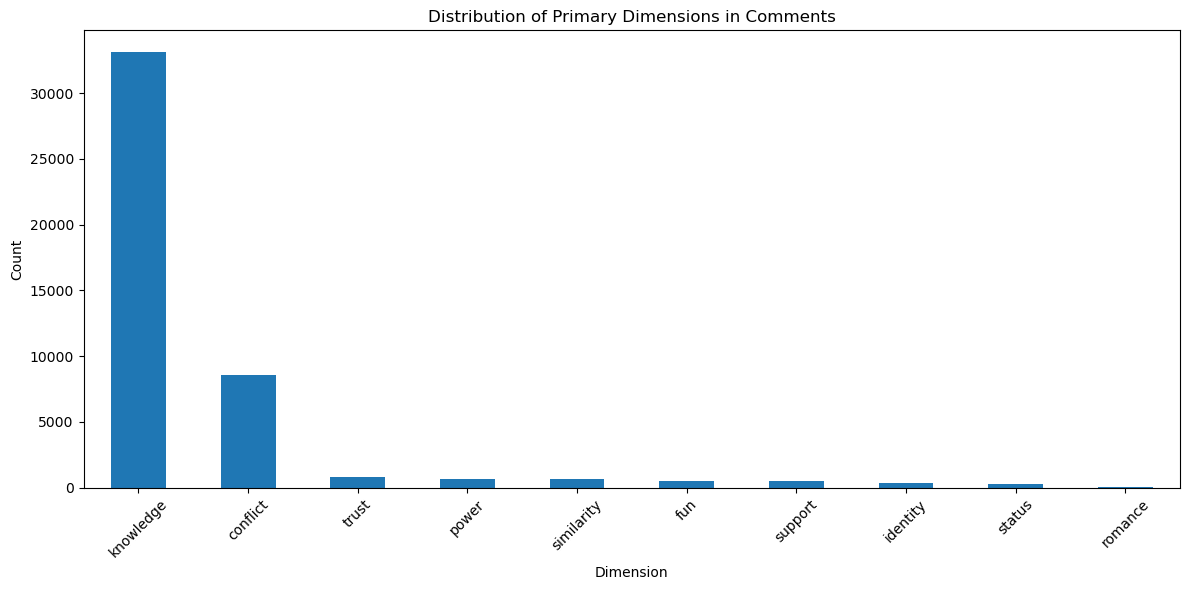

In [53]:
######## this is wrong 



def analyze_comment_dimensions(df, threshold=0.5, use_mean=True):
    """
    Analyze dimensions for comments based on their scores
    
    Args:
        df: DataFrame with dimension scores
        threshold: Minimum score to consider a dimension dominant
        use_mean: Whether to use mean scores (True) or max scores (False)
    
    Returns:
        DataFrame with new columns for dimension analysis
    """
    # List of dimensions
    dimensions_list = ['support', 'knowledge', 'conflict', 'power', 'similarity',
                      'fun', 'status', 'trust', 'identity', 'romance']
    
    # Create copy to avoid modifying original
    result_df = df.copy()
    
    def get_dominant_dimensions(row):
        # Get scores for each dimension
        scores = {dim: row[f'{dim}_mean'] if use_mean else row[f'{dim}_max'] 
                 for dim in dimensions_list}
        
        # Get dimensions above threshold
        dominant = [dim for dim, score in scores.items() 
                   if score >= threshold]
        
        # Get primary dimension (highest scoring)
        primary = max(scores.items(), key=lambda x: x[1])[0]
        
        # Get score of primary dimension
        primary_score = scores[primary]
        
        return pd.Series({
            'dominant_dimensions': dominant,
            'primary_dimension': primary,
            'primary_dimension_score': primary_score,
            'num_dominant_dimensions': len(dominant)
        })
    
    # Add new columns
    result_df[['dominant_dimensions', 'primary_dimension', 
               'primary_dimension_score', 'num_dominant_dimensions']] = df.apply(get_dominant_dimensions, axis=1)
    
    return result_df

# Use the function
# You can adjust the threshold as needed
analyzed_data = analyze_comment_dimensions(data, threshold=0.5)

# Print some sample results
print("\nSample analysis:")
sample = analyzed_data.iloc[0]
print(f"Comment: {sample['cleaned_body'][:100]}...")
print(f"Dominant dimensions: {sample['dominant_dimensions']}")
print(f"Primary dimension: {sample['primary_dimension']} (score: {sample['primary_dimension_score']:.3f})")
print(f"Number of dominant dimensions: {sample['num_dominant_dimensions']}")

# Get some statistics
print("\nDistribution of primary dimensions:")
print(analyzed_data['primary_dimension'].value_counts())

print("\nAverage number of dominant dimensions per comment:")
print(analyzed_data['num_dominant_dimensions'].mean())

# Optional: Create a bar plot of dimension distribution
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    analyzed_data['primary_dimension'].value_counts().plot(kind='bar')
    plt.title('Distribution of Primary Dimensions in Comments')
    plt.xlabel('Dimension')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not available for plotting")

In [55]:
data.columns.tolist()

['level_0',
 'index',
 'post_id',
 'link_id',
 'subreddit',
 'parent_id',
 'redditor_id',
 'created_at',
 'body',
 'score',
 'edited',
 'parent_id_clean',
 'has_delta',
 'title',
 'text',
 'permalink',
 'post_id_parent',
 'redditor_id_parent',
 'cleaned_text',
 'cleaned_body',
 'is_climate_related',
 'num_sentences_cleaned_body',
 'num_sentences_cleaned_text',
 'num_sentences_body',
 'num_sentences_text',
 'word_count_text',
 'token_count_text',
 'word_count_body',
 'token_count_body',
 'summarized_cleaned_bod',
 'summarized_cleaned_text',
 'support_mean',
 'support_max',
 'support_min',
 'support_std',
 'knowledge_mean',
 'knowledge_max',
 'knowledge_min',
 'knowledge_std',
 'conflict_mean',
 'conflict_max',
 'conflict_min',
 'conflict_std',
 'power_mean',
 'power_max',
 'power_min',
 'power_std',
 'similarity_mean',
 'similarity_max',
 'similarity_min',
 'similarity_std',
 'fun_mean',
 'fun_max',
 'fun_min',
 'fun_std',
 'status_mean',
 'status_max',
 'status_min',
 'status_std',
 't

In [65]:
def get_dimension_with_criteria(row):
    """
    Find dimension based on both mean and std criteria:
    - If difference between means is small (<0.1), choose dimension with smaller std
    - Otherwise, choose dimension with highest mean
    """
    # Create dictionary of dimensions with their mean and std values
    dimension_scores = {
        'support': (row['support_mean'], row['support_std']),
        'knowledge': (row['knowledge_mean'], row['knowledge_std']),
        'conflict': (row['conflict_mean'], row['conflict_std']),
        'power': (row['power_mean'], row['power_std']),
        'similarity': (row['similarity_mean'], row['similarity_std']),
        'fun': (row['fun_mean'], row['fun_std']),
        'status': (row['status_mean'], row['status_std']),
        'trust': (row['trust_mean'], row['trust_std']),
        'identity': (row['identity_mean'], row['identity_std']),
        'romance': (row['romance_mean'], row['romance_std'])
    }
    
    # Get highest mean score
    max_mean = max(score[0] for score in dimension_scores.values())
    
    # Get all dimensions within 0.1 of the highest mean
    close_dimensions = {dim: scores for dim, scores in dimension_scores.items() 
                       if max_mean - scores[0] < 0.1}
    
    if len(close_dimensions) > 1:
        # If multiple dimensions are close in mean, choose one with smallest std
        return min(close_dimensions.items(), key=lambda x: x[1][1])[0]
    else:
        # Otherwise, return dimension with highest mean
        return max(dimension_scores.items(), key=lambda x: x[1][0])[0]

# Apply to DataFrame
data['dimension'] = data.apply(get_dimension_with_criteria, axis=1)

# Optional: Add the mean and std of the chosen dimension
#data['dimension_mean'] = data.apply(lambda row: row[f"{row['dimension']}_mean"], axis=1)
#data['dimension_std'] = data.apply(lambda row: row[f"{row['dimension']}_std"], axis=1)

In [67]:
data.columns.tolist()

['level_0',
 'index',
 'post_id',
 'link_id',
 'subreddit',
 'parent_id',
 'redditor_id',
 'created_at',
 'body',
 'score',
 'edited',
 'parent_id_clean',
 'has_delta',
 'title',
 'text',
 'permalink',
 'post_id_parent',
 'redditor_id_parent',
 'cleaned_text',
 'cleaned_body',
 'is_climate_related',
 'num_sentences_cleaned_body',
 'num_sentences_cleaned_text',
 'num_sentences_body',
 'num_sentences_text',
 'word_count_text',
 'token_count_text',
 'word_count_body',
 'token_count_body',
 'summarized_cleaned_bod',
 'summarized_cleaned_text',
 'support_mean',
 'support_max',
 'support_min',
 'support_std',
 'knowledge_mean',
 'knowledge_max',
 'knowledge_min',
 'knowledge_std',
 'conflict_mean',
 'conflict_max',
 'conflict_min',
 'conflict_std',
 'power_mean',
 'power_max',
 'power_min',
 'power_std',
 'similarity_mean',
 'similarity_max',
 'similarity_min',
 'similarity_std',
 'fun_mean',
 'fun_max',
 'fun_min',
 'fun_std',
 'status_mean',
 'status_max',
 'status_min',
 'status_std',
 't

In [77]:
data[['cleaned_body','dimension']].head(10)

,cleaned_body,dimension
0,"yes, sub-saharan africa is the area that lies ...",identity
1,but then how do we know there isn't just one r...,knowledge
2,yeah i think around the bengal area is where s...,knowledge
3,just because its not utilitarian or useful in ...,conflict
4,i was hoping youd think it obvious that ethnic...,knowledge
5,"africa, as the birthplace of humanity, has the...",knowledge
6,/u/ubcguy (op) has awarded 1 delta(s) in this ...,knowledge
7,native americans out here like... uh... what a...,knowledge
8,south sudan and chad are taller than the world...,conflict
9,"wait, there are three primary races? that seem...",knowledge


In [99]:
# Remove the specified columns if they exist
columns_to_drop = ['dimension', 'dimension_mean', 'dimension_std']
data = data.drop(columns=columns_to_drop, errors='ignore')

# Verify the columns are removed
print("Remaining columns:", len(data.columns))
print("Columns were successfully removed")

Remaining columns: 111
Columns were successfully removed


In [101]:
data.columns.tolist()

['level_0',
 'index',
 'post_id',
 'link_id',
 'subreddit',
 'parent_id',
 'redditor_id',
 'created_at',
 'body',
 'score',
 'edited',
 'parent_id_clean',
 'has_delta',
 'title',
 'text',
 'permalink',
 'post_id_parent',
 'redditor_id_parent',
 'cleaned_text',
 'cleaned_body',
 'is_climate_related',
 'num_sentences_cleaned_body',
 'num_sentences_cleaned_text',
 'num_sentences_body',
 'num_sentences_text',
 'word_count_text',
 'token_count_text',
 'word_count_body',
 'token_count_body',
 'summarized_cleaned_bod',
 'summarized_cleaned_text',
 'support_mean',
 'support_max',
 'support_min',
 'support_std',
 'knowledge_mean',
 'knowledge_max',
 'knowledge_min',
 'knowledge_std',
 'conflict_mean',
 'conflict_max',
 'conflict_min',
 'conflict_std',
 'power_mean',
 'power_max',
 'power_min',
 'power_std',
 'similarity_mean',
 'similarity_max',
 'similarity_min',
 'similarity_std',
 'fun_mean',
 'fun_max',
 'fun_min',
 'fun_std',
 'status_mean',
 'status_max',
 'status_min',
 'status_std',
 't

In [131]:
def analyze_primary_dimensions(data):
    # Apply dimension labeling
    data['primary_dimension'] = data.apply(get_dimension_with_criteria, axis=1)
    
    # Calculate for each primary dimension
    results = []
    for dim in data['primary_dimension'].unique():
        dim_comments = data[data['primary_dimension'] == dim]
        total = len(dim_comments)
        deltas = len(dim_comments[dim_comments['has_delta'] == 1])
        
        results.append({
            'dimension': dim,
            'total_comments': total,
            'delta_comments': deltas,
            'delta_rate': deltas/total if total > 0 else 0,
            'mean_score': dim_comments[f'{dim}_mean'].mean()
        })
    
    results_df = pd.DataFrame(results).sort_values('delta_rate', ascending=False)
    
    # Visualization
    plt.figure(figsize=(12, 6), dpi=300)
    
    # Plot delta rates
    plt.subplot(1, 2, 1)
    sns.barplot(data=results_df, x='delta_rate', y='dimension')
    plt.title('Delta Rate by Primary Dimension')
    plt.xlabel('Delta Rate')
    
    # Plot comment counts
    plt.subplot(1, 2, 2)
    sns.barplot(data=results_df, x='total_comments', y='dimension')
    plt.title('Number of Comments by Primary Dimension')
    plt.xlabel('Number of Comments')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Run analysis
results = analyze_primary_dimensions(data)
print("\nResults by primary dimension:")
print(results[['dimension', 'total_comments', 'delta_rate', 'mean_score']])

# Let's test it with your example
test_row = pd.Series({
    'similarity_mean': 0.993, 'similarity_std': 0.014,
    'knowledge_mean': 0.630, 'knowledge_std': 0.015,
    'romance_mean': 0.912, 'romance_std': 0.011,
    'conflict_mean': 0.911, 'conflict_std': 0.011,
    'status_mean': 0.136, 'status_std': 0.025,
    'fun_mean': 0.046, 'fun_std': 0.030,
    'power_mean': 0.011, 'power_std': 0.035,
    'support_mean': 0.011, 'support_std': 0.040,
    'trust_mean': 0.500, 'trust_std': 0.045,
    'identity_mean': 0.800, 'identity_std': 0.050
})

result = get_dimension_with_criteria(test_row)
print("Selected dimension:", result)

# let's apply it on all dataset.


Selected dimension: romance


In [133]:
# Apply the function to each row and create new 'dimension' column
data['dimension'] = data.apply(get_dimension_with_criteria, axis=1)

# Print some verification information
print("Distribution of dimensions:")
print(data['dimension'].value_counts())

# Optional: get percentage distribution
print("\nPercentage distribution:")
print(data['dimension'].value_counts(normalize=True) * 100)

# Verify some random samples
print("\nRandom sample verification:")
sample_rows = data.sample(n=5)
for idx, row in sample_rows.iterrows():
    print(f"\nIndex {idx}:")
    print(f"Text: {row['cleaned_body'][:100]}...")
    print(f"Assigned dimension: {row['dimension']}")
    print(f"Top 3 means:")
    # Get top 3 mean scores for verification
    means = [(dim, row[f'{dim}_mean']) for dim in ['support', 'knowledge', 'conflict', 'power', 
                                                  'similarity', 'fun', 'status', 'trust', 
                                                  'identity', 'romance']]
    top_3 = sorted(means, key=lambda x: x[1], reverse=True)[:3]
    for dim, mean in top_3:
        print(f"{dim}: {mean:.4f} (std: {row[f'{dim}_std']:.4f})")

Distribution of dimensions:
dimension
knowledge     29171
conflict       8307
identity       3955
similarity     1069
power           922
trust           732
support         508
fun             437
status          206
romance          60
Name: count, dtype: int64

Percentage distribution:
dimension
knowledge     64.300042
conflict      18.310666
identity       8.717790
similarity     2.356338
power          2.032314
trust          1.613508
support        1.119757
fun            0.963255
status         0.454075
romance        0.132255
Name: proportion, dtype: float64

Random sample verification:

Index 4749:
Text: (sorry, this got really long as it taps into a few things that i'm really passionate about!) oof, 28...
Assigned dimension: knowledge
Top 3 means:
knowledge: 0.6264 (std: 0.2315)
similarity: 0.4674 (std: 0.2482)
identity: 0.4559 (std: 0.0997)

Index 17438:
Text: i think this answers the cmv, but not in the way expected. people care because somehow the palestini...
Assigned dim

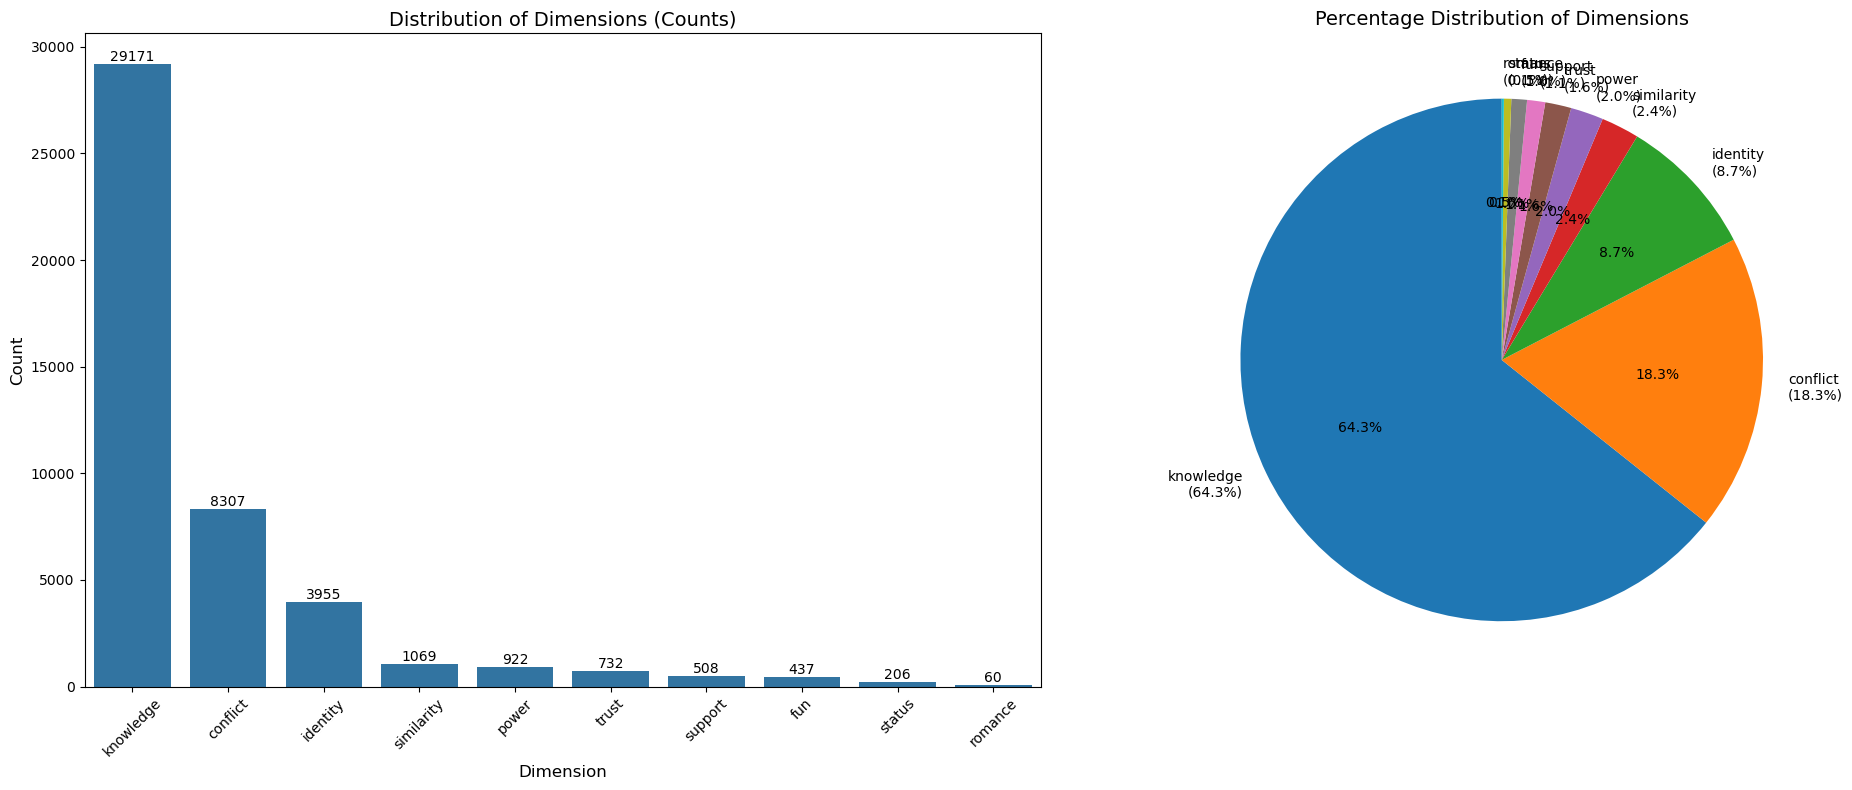

In [134]:
# Now add visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with two subplots side by side
plt.figure(figsize=(20, 8))

# 1. Bar plot for counts
plt.subplot(1, 2, 1)
counts = data['dimension'].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.title('Distribution of Dimensions (Counts)', fontsize=14)
plt.xlabel('Dimension', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add count labels on top of bars
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# 2. Pie chart for percentages
plt.subplot(1, 2, 2)
percentages = data['dimension'].value_counts(normalize=True) * 100
plt.pie(percentages, labels=[f'{dim}\n({pct:.1f}%)' for dim, pct in zip(percentages.index, percentages)],
        autopct='%1.1f%%', startangle=90)
plt.title('Percentage Distribution of Dimensions', fontsize=14)

# Adjust layout and display
plt.tight_layout()
plt.show()

Distribution of dimensions in posts:
dimension_text
knowledge     40528
conflict       3315
identity       1450
similarity       74
Name: count, dtype: int64

Percentage distribution in posts:
dimension_text
knowledge     89.333657
conflict       7.307073
identity       3.196156
similarity     0.163114
Name: proportion, dtype: float64

Random sample verification:

Index 2173:
Text: planetary survival should be above the prime directive. if a planet is going to die out because of d...
Assigned dimension: knowledge
Top 3 means:
knowledge: 0.8143 (std: 0.1946)
identity: 0.4708 (std: 0.0881)
conflict: 0.4329 (std: 0.2759)

Index 10502:
Text: i only say americans because i am one and dont know enough about the culture outside america enough ...
Assigned dimension: knowledge
Top 3 means:
knowledge: 0.7032 (std: 0.2198)
conflict: 0.4571 (std: 0.2580)
identity: 0.4405 (std: 0.0831)

Index 31272:
Text: i think women have immense power in their social circles, and collectively this is enough pow

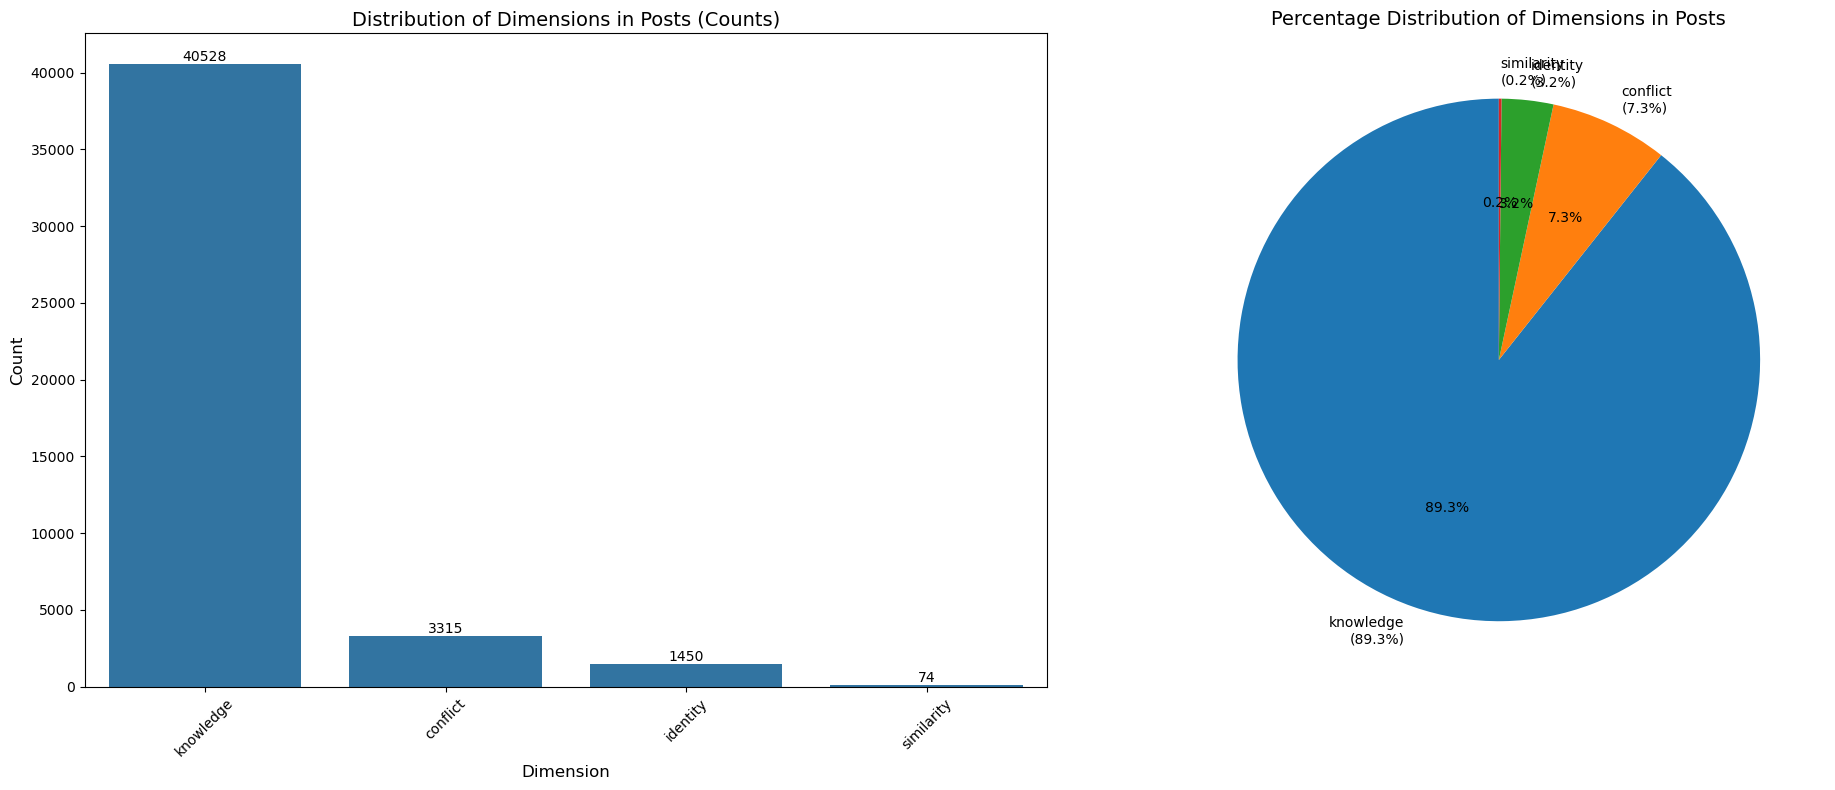

In [153]:
def get_dimension_with_criteria_text(row):
    """
    Find dimension based on top 3 means and their std for posts
    Using the '_text' suffix columns
    """
    dimension_scores = {
        'support': (row['support_mean_text'], row['support_std_text']),
        'knowledge': (row['knowledge_mean_text'], row['knowledge_std_text']),
        'conflict': (row['conflict_mean_text'], row['conflict_std_text']),
        'power': (row['power_mean_text'], row['power_std_text']),
        'similarity': (row['similarity_mean_text'], row['similarity_std_text']),
        'fun': (row['fun_mean_text'], row['fun_std_text']),
        'status': (row['status_mean_text'], row['status_std_text']),
        'trust': (row['trust_mean_text'], row['trust_std_text']),
        'identity': (row['identity_mean_text'], row['identity_std_text']),
        'romance': (row['romance_mean_text'], row['romance_std_text'])
    }
    
    # Sort dimensions by mean score and get top 3
    top_3 = sorted(dimension_scores.items(), key=lambda x: x[1][0], reverse=True)[:3]
    
    # Get highest mean from top 3
    highest_mean = top_3[0][1][0]
    
    # Check which of top 3 are within 0.08 of highest mean
    close_dimensions = [(dim, scores) for dim, scores in top_3 
                       if highest_mean - scores[0] < 0.15]
    
    if len(close_dimensions) > 1:
        # If multiple dimensions are close in mean, choose one with smallest std
        return min(close_dimensions, key=lambda x: x[1][1])[0]
    else:
        # Otherwise, return dimension with highest mean
        return top_3[0][0]

# Apply the function to each row and create new 'dimension_text' column
data['dimension_text'] = data.apply(get_dimension_with_criteria_text, axis=1)

# Print some verification information
print("Distribution of dimensions in posts:")
print(data['dimension_text'].value_counts())

# Get percentage distribution
print("\nPercentage distribution in posts:")
print(data['dimension_text'].value_counts(normalize=True) * 100)

# Verify some random samples
print("\nRandom sample verification:")
sample_rows = data.sample(n=30)
for idx, row in sample_rows.iterrows():
    print(f"\nIndex {idx}:")
    print(f"Text: {row['cleaned_text'][:100]}...")
    print(f"Assigned dimension: {row['dimension_text']}")
    print(f"Top 3 means:")
    means = [(dim, row[f'{dim}_mean_text']) for dim in ['support', 'knowledge', 'conflict', 'power', 
                                                       'similarity', 'fun', 'status', 'trust', 
                                                       'identity', 'romance']]
    top_3 = sorted(means, key=lambda x: x[1], reverse=True)[:3]
    for dim, mean in top_3:
        print(f"{dim}: {mean:.4f} (std: {row[f'{dim}_std_text']:.4f})")

# Create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with two subplots side by side
plt.figure(figsize=(20, 8))

# 1. Bar plot for counts
plt.subplot(1, 2, 1)
counts = data['dimension_text'].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.title('Distribution of Dimensions in Posts (Counts)', fontsize=14)
plt.xlabel('Dimension', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add count labels on top of bars
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# 2. Pie chart for percentages
plt.subplot(1, 2, 2)
percentages = data['dimension_text'].value_counts(normalize=True) * 100
plt.pie(percentages, labels=[f'{dim}\n({pct:.1f}%)' for dim, pct in zip(percentages.index, percentages)],
        autopct='%1.1f%%', startangle=90)
plt.title('Percentage Distribution of Dimensions in Posts', fontsize=14)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [143]:
# First, create a DataFrame with unique posts
unique_posts = data.drop_duplicates(subset=['link_id'])
print(f"Total number of unique posts: {len(unique_posts)}")

Total number of unique posts: 236


Total number of unique posts: 236

Distribution of dimensions in unique posts:
                Count  Percentage
dimension_text                   
knowledge         216       91.53
conflict           14        5.93
identity            5        2.12
similarity          1        0.42

Random sample verification:

Link ID: wfrjz2
Text: global co2 emissions were 31.5 gt( thats 31500000000 tons. taylor generated 8,293.54 tons( so taylor...
Assigned dimension: knowledge
Top 3 means:
knowledge: 0.8596 (std: 0.1671)
conflict: 0.4673 (std: 0.2212)
identity: 0.4517 (std: 0.0641)

Link ID: kgy3jj
Text: prageru( is an american media company that specializes in producing propaganda for the american cons...
Assigned dimension: knowledge
Top 3 means:
knowledge: 0.7943 (std: 0.2090)
identity: 0.5033 (std: 0.0754)
conflict: 0.4400 (std: 0.2761)

Link ID: 15525gb
Text: cmv: with the beginning of global warming, it makes sense to purchase property that is near the beac...
Assigned dimension: knowledge
To

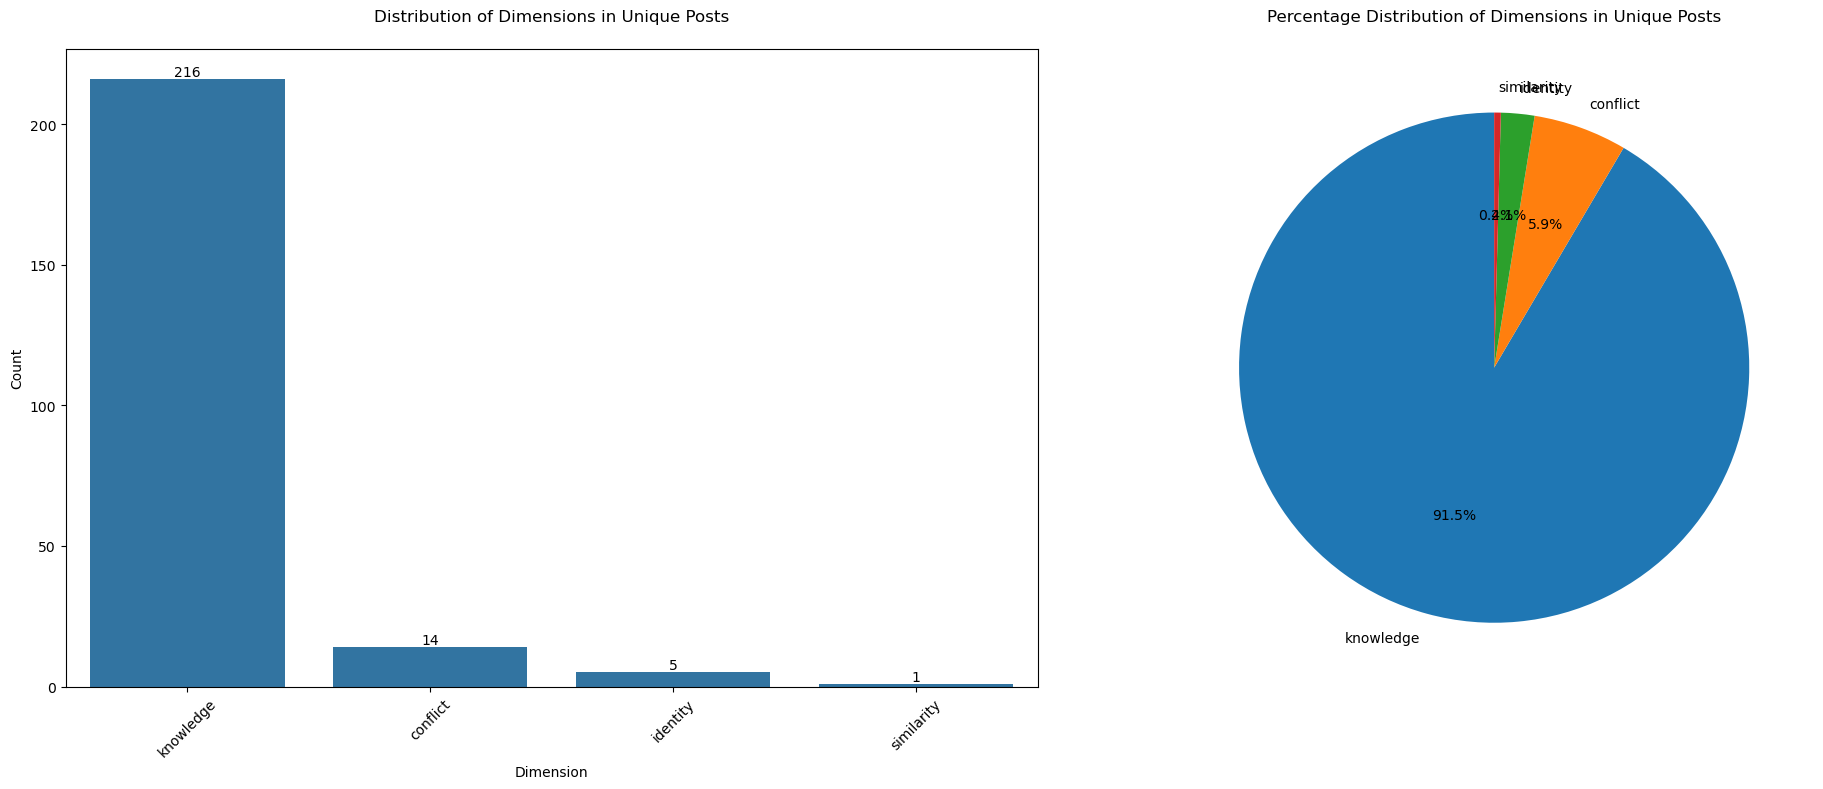

In [147]:
# First, create a DataFrame with unique posts using link_id
unique_posts = data.drop_duplicates(subset=['link_id'])
print(f"Total number of unique posts: {len(unique_posts)}")


# Print distributions
print("\nDistribution of dimensions in unique posts:")
dimension_counts = unique_posts['dimension_text'].value_counts()
dimension_percentages = unique_posts['dimension_text'].value_counts(normalize=True) * 100

# Create a DataFrame for side-by-side display of counts and percentages
distribution_df = pd.DataFrame({
    'Count': dimension_counts,
    'Percentage': dimension_percentages.round(2)
})
print(distribution_df)

# Sample verification
print("\nRandom sample verification:")
sample_rows = unique_posts.sample(n=5)
for idx, row in sample_rows.iterrows():
    print(f"\nLink ID: {row['link_id']}")
    print(f"Text: {row['cleaned_text'][:100]}...")
    print(f"Assigned dimension: {row['dimension_text']}")
    print(f"Top 3 means:")
    means = [(dim, row[f'{dim}_mean_text']) for dim in ['support', 'knowledge', 'conflict', 'power', 
                                                       'similarity', 'fun', 'status', 'trust', 
                                                       'identity', 'romance']]
    top_3 = sorted(means, key=lambda x: x[1], reverse=True)[:3]
    for dim, mean in top_3:
        print(f"{dim}: {mean:.4f} (std: {row[f'{dim}_std_text']:.4f})")

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Bar plot
sns.barplot(x=distribution_df.index, y='Count', data=distribution_df, ax=ax1)
ax1.set_title('Distribution of Dimensions in Unique Posts', pad=20)
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, v in enumerate(distribution_df['Count']):
    ax1.text(i, v, str(int(v)), ha='center', va='bottom')

# Pie chart
wedges, texts, autotexts = ax2.pie(distribution_df['Percentage'], 
                                  labels=distribution_df.index,
                                  autopct='%1.1f%%',
                                  startangle=90)
ax2.set_title('Percentage Distribution of Dimensions in Unique Posts', pad=20)

# Adjust layout
plt.tight_layout()
plt.show()

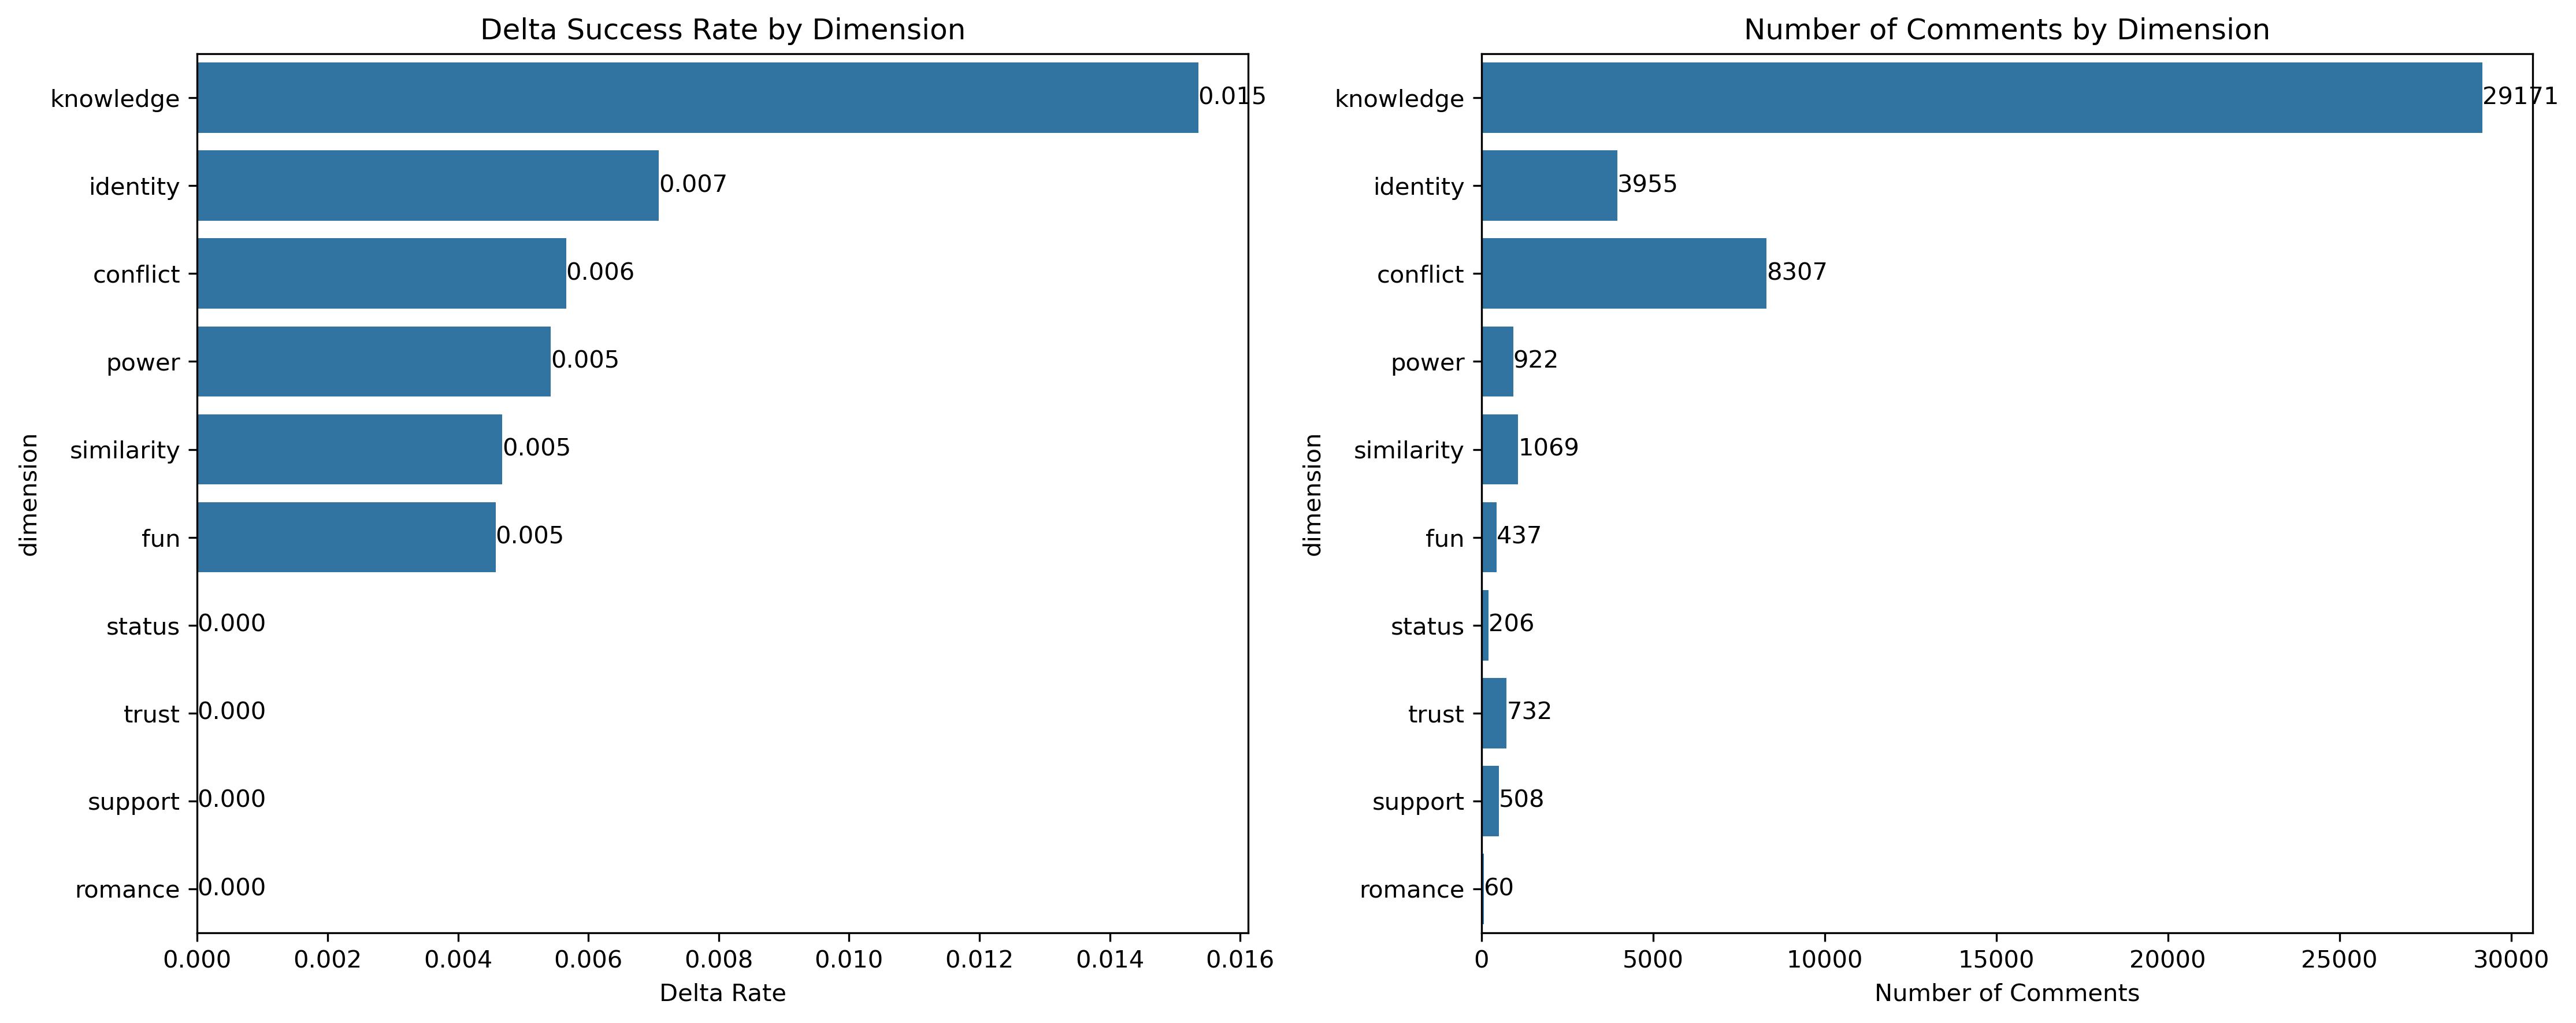


Results sorted by delta rate:
    dimension  total_comments  delta_comments  delta_rate  mean_score
1   knowledge           29171             448    0.015358    0.808523
0    identity            3955              28    0.007080    0.516194
2    conflict            8307              47    0.005658    0.746998
4       power             922               5    0.005423    0.722577
3  similarity            1069               5    0.004677    0.658283
7         fun             437               2    0.004577    0.714339
5      status             206               0    0.000000    0.680872
6       trust             732               0    0.000000    0.703877
8     support             508               0    0.000000    0.597422
9     romance              60               0    0.000000    0.819782


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# loading dataset: 

#llm_opinion/newdatasets/datasetgroup/output/tendims_final2.csv

#C:\Users\mitra\llm_opinion\newdatasets\datasetgroup\output
data= pd.read_csv("C:/Users/mitra/llm_opinion/newdatasets/datasetgroup/output/tendims_final2.csv") 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dimensions(data):
    # Calculate statistics per dimension
    results = []
    for dim in data['dimension'].unique():
        dim_comments = data[data['dimension'] == dim]
        total = len(dim_comments)
        deltas = len(dim_comments[dim_comments['has_delta'] == 1])
        
        results.append({
            'dimension': dim,
            'total_comments': total,
            'delta_comments': deltas,
            'delta_rate': deltas/total if total > 0 else 0,
            'mean_score': dim_comments[f'{dim}_mean'].mean()
        })
    
    results_df = pd.DataFrame(results).sort_values('delta_rate', ascending=False)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
    
    # Delta rates
    sns.barplot(data=results_df, y='dimension', x='delta_rate', ax=ax1)
    ax1.set_title('Delta Success Rate by Dimension')
    ax1.set_xlabel('Delta Rate')
    
    # Add value labels
    for i, v in enumerate(results_df['delta_rate']):
        ax1.text(v, i, f'{v:.3f}', va='center')
    
    # Comment counts
    sns.barplot(data=results_df, y='dimension', x='total_comments', ax=ax2)
    ax2.set_title('Number of Comments by Dimension')
    ax2.set_xlabel('Number of Comments')
    
    # Add value labels
    for i, v in enumerate(results_df['total_comments']):
        ax2.text(v, i, str(int(v)), va='center')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Run analysis
results = analyze_dimensions(data)
print("\nResults sorted by delta rate:")
print(results[['dimension', 'total_comments', 'delta_comments', 'delta_rate', 'mean_score']])

In [151]:
output_file = "../data/tendims_final2.csv"
data.to_csv(output_file, index=False)
print("Saved file to:", output_file)

Saved file to: ../data/tendims_final2.csv


In [ ]:
# # examples
# sentences = {
# 'knowledge' : [
#     "Only a fully trained Jedi Knight, with The Force as his ally, will conquer Vader and his Emperor. If you end your training now, if you choose the quick and easy path, as Vader did, you will become an agent of evil",
#     "Well, in layman's terms, you use a rotating magnetic field to focus a narrow beam of gravitons; these in turn fold space-time consistent with Weyl tensor dynamics until the space-time curvature becomes infinitely large and you have a singularity",
#     "Since positronic signatures have only been known to emanate from androids such as myself, it is logical to theorize that there is an android such as myself on Kolarus III",
# ],

# 'power' : [
#     "Now if you don't want to be the fifth person ever to die in meta-shock from a planar rift, I suggest you get down behind that desk and don't move until we give you the signal",
#     "You can ask any price you want, but you must give me those letters ",
#     "Right now you're in no position to ask questions! And your snide remarks..."
# ],

# 'status' : [
#     "I want to thank you, sir, for giving me the opportunity to work",
#     "Frankie, you're a good old man, and you've been loyal to my Father for years...so I hope you can explain what you mean",
#     "And we drink to her, and we all congratulate her on her wonderful accomplishment during this last year...her great success in A Doll's House!"
# ],

# 'trust' : [
#     "I'm trying to tell you – and this is where you have to trust me – but, I think your life might be in real danger",
#     "Mr. Lebowski is prepared to make a generous offer to you to act as courier once we get instructions for the money",
#     "Take the Holy Gospels in your hand and swear to tell the whole truth concerning everything you will be asked"
# ],

# 'support' : [
#     "I'm sorry, I just feel like... I know I shouldn't ask, I just need some kind of help, I just, I have a deadline tomorrow",
#     "Look, Dave, I know that you're sincere and that you're trying to do a competent job, and that you're trying to be helpful, but I can assure the problem is with the AO-units, and with your test gear",
#     "Well... listen, if you need any help, you know, back up, call me, OK?"
# ],

# 'romance' : [
#     "I'm going to marry the woman I love",
#     "If you are truly wild at heart, you'll fight for your dreams... Don’t turn away from love, Sailor ",
#     "You admit to me you do not love your fiance?"
# ],

# 'identity' : [
#     "Hey, I know what I'm talkin' about, black women ain't the same as white women ",
#     "That's how it was in the old world, Pop, but this is not Sicily",
#     "But, as you are so fond of observing, Doctor, I'm not human"
# ],

# 'fun' : [
#     "It’s just funny...who needs a serial psycho in the woods with a chainsaw when we have ourselves",
#     "I do enjoy playing bingo, if you'd like to join me for a game tomorrow night at church you’re welcome to",
#     "Oh, I'm sure it’s a lot of fun, 'cause the Incas did it, you know, and-and they-they-they were a million laughs"
# ],

# 'conflict' : [
#     "Forgive me for askin', son, and I don’t mean to belabor the obvious, but why is it that you’ve got your head so far up your own ass?",
#     "If you're lying to me you poor excuse for a human being, I'm gonna blow your brains all over this car",
#     "I couldn't give a shit if you believe me or not, and frankly I'm too tired to prove it to you"
# ]}

In [ ]:
# for dim in sentences:
#     print(f' === {dim.upper()} ===')
#     for s in sentences[dim]:
#         score = model.compute_score(s, dim)
#         print (f'{s} -- {dim}={score:.2f}')